Feature ranking:
1. feature 13 (0.120014)
2. feature 10 (0.097948)
3. feature 1 (0.080902)
4. feature 2 (0.078667)
5. feature 0 (0.074051)
6. feature 16 (0.066203)
7. feature 3 (0.065188)
8. feature 19 (0.060735)
9. feature 17 (0.056194)
10. feature 18 (0.054324)
11. feature 5 (0.051904)
12. feature 7 (0.044639)
13. feature 12 (0.031920)
14. feature 6 (0.022195)
15. feature 4 (0.021145)
16. feature 23 (0.020393)
17. feature 9 (0.016672)
18. feature 15 (0.007930)
19. feature 14 (0.007829)
20. feature 8 (0.006262)
21. feature 21 (0.004622)
22. feature 22 (0.003786)
23. feature 11 (0.003539)
24. feature 20 (0.002940)


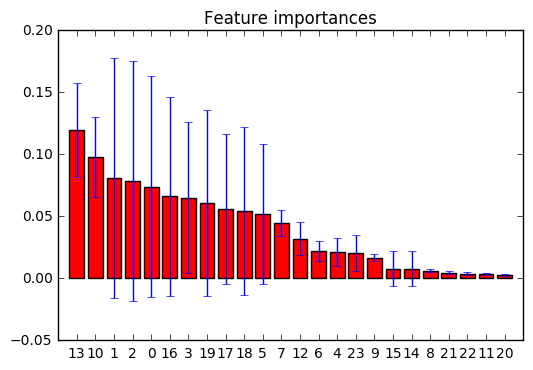

Confusion matrix, without normalization
[[707  23  31]
 [172 226  59]
 [ 33  15 734]]
Normalized confusion matrix
[[ 0.93  0.03  0.04]
 [ 0.38  0.49  0.13]
 [ 0.04  0.02  0.94]]


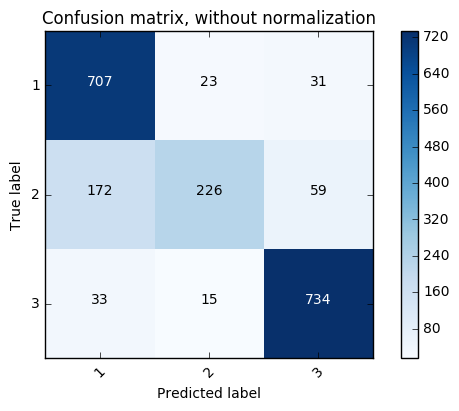

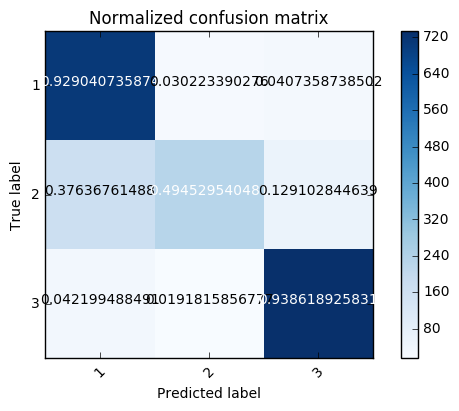

In [9]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import sqlite3

from sklearn import svm, datasets, metrics, tree, preprocessing
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from time import time

from StringIO import StringIO
from IPython.display import Image

#Gera uma amostra de 8000 registros
#Este script tem o proposito de gerar imagens ilustrativas para compor o trabalho de conclusao
#Essas imagens vao auxiliar na explicacao dos conceitos

con = sqlite3.connect("database.sqlite")
df = pd.read_sql_query("""SELECT 
funded_amnt ,
funded_amnt_inv,
loan_amnt ,
cast (replace( term, ' months', '' ) as FLOAT) as term_float,
cast (replace( int_rate, '%', '' ) as FLOAT) as int_rate_float,
installment ,
annual_inc ,
dti ,
delinq_2yrs ,
inq_last_6mths ,
open_acc ,
pub_rec ,
revol_bal ,
total_acc ,
out_prncp ,
out_prncp_inv,
total_pymnt ,
total_pymnt_inv,
total_rec_prncp ,
total_rec_int ,
total_rec_late_fee ,
recoveries ,
collection_recovery_fee ,
last_pymnt_amnt from loan WHERE
funded_amnt IS NOT NULL AND
loan_amnt IS NOT NULL AND
term_float IS NOT NULL AND
int_rate_float IS NOT NULL AND
installment IS NOT NULL AND
emp_length IS NOT NULL AND
annual_inc IS NOT NULL AND
dti IS NOT NULL AND
delinq_2yrs IS NOT NULL AND
inq_last_6mths IS NOT NULL AND
open_acc IS NOT NULL AND
pub_rec IS NOT NULL AND
revol_bal IS NOT NULL AND
total_acc IS NOT NULL AND
out_prncp IS NOT NULL AND
total_pymnt IS NOT NULL AND
total_rec_prncp IS NOT NULL AND
total_rec_int IS NOT NULL AND
total_rec_late_fee IS NOT NULL AND
recoveries IS NOT NULL AND
collection_recovery_fee IS NOT NULL AND
last_pymnt_amnt IS NOT NULL limit 8000
""", con)

np.random.seed(42)

data = scale(df)


reduced_data = preprocessing.normalize(data)

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

y = kmeans.labels_

clf = tree.DecisionTreeClassifier()
clf = clf.fit(reduced_data, y)

feature_names = [
"funded_amnt" ,
"funded_amnt_inv",    
"loan_amnt" ,
"term_float",
"int_rate_float",
"installment" ,
"annual_inc" ,
"dti" ,
"delinq_2yrs" ,
"inq_last_6mths" ,
"open_acc" ,
"pub_rec" ,
"revol_bal" ,
"total_acc" ,
"out_prncp" ,
"out_prncp_inv",
"total_pymnt" ,
"total_pymnt_inv",
"total_rec_prncp" ,
"total_rec_int" ,
"total_rec_late_fee" ,
"recoveries" ,
"collection_recovery_fee" ,
"last_pymnt_amnt"
]
target_names = ["1", "2", "3"]

out = StringIO() 
dot_data = StringIO()

tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_names,  
                         class_names=target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png("loan.png")



# import some data to play with

X = df
y = kmeans.labels_
class_names = ['1', '2', '3']


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(X_train, y_train).predict(X_test)


random = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

# we create an instance of Neighbours Classifier and fit the data.
#trained = random.fit(X_train, y_train)
y_pred = random.fit(X_train, y_train).predict(X_test)

#print "Score random: {0}" % random.score()


#Build a classification task using 3 informative features
X, y = df, kmeans.labels_
#Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
#Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.savefig('tree-most-important-features.png', bbox_inches='tight')
plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('confusionMatrixRanFor.png', bbox_inches='tight')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()